In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] ='3'
import tensorflow as tf


# Import models

In [150]:
import joblib
xgb_model = joblib.load('./Models/XGBoost_model.joblib')
xgb_mc_model = joblib.load('./Models/XGBoost_manual_cat_model.joblib')
grb_model = joblib.load('./Models/GRBoost_model.joblib')
lm_model = joblib.load('./Models/LM_model.joblib')
rf_model = joblib.load('./Models/RF_model.joblib')
svr_model = joblib.load('./Models/SVR_model.joblib')
sk_voting_model = joblib.load('./Models/SklearnVoting_model.joblib')
tf_model = tf.keras.models.load_model("./Models/tf_model")

# Data preparation

## Import data with outliers (>= 90 percentile) removed in preprocessing

In [151]:
data = pd.read_csv('../Data/LT_DU_data_for_ML.csv')
data.head()

,nace,esize_class,gender,age_class,lpk,education,experience,target
0,C,1_49,M,40-49,p721,G2,13,8.20
1,C,1_49,F,40-49,p334,G2,0,2.51
2,M,50_249,F,40-49,p522,G2,18,2.19
3,M,50_249,F,40-49,p522,G2,12,2.19
4,M,50_249,F,14-29,p522,G2,0,2.19


## Most common values and max of numeric feature

In [152]:
median_experience = data['experience'].median()
max_experience = data['experience'].max()
most_common = data[['nace', 'esize_class', 'gender', 'age_class', 'lpk', 'education']].mode()
most_common['experience'] = median_experience

## Unique categorical feature values

In [153]:
nace = np.sort(data['nace'].unique())
gender = data['gender'].unique()
esize_class = np.array(['1_49', '50_249','GT_250'], dtype=object)
age_class = np.array(['14-29','30-39', '40-49', '50-59','60+'], dtype=object)
education = np.array([ 'G1', 'G2', 'G3', 'G4'], dtype=object)
lpk = np.sort(data['lpk'].unique())

# Functions to create datasets and apply models

In [154]:
def unique_feature_values_with_other_most_common(feature):
    unique_values = np.sort(data[feature].unique())
    length = len(unique_values)
    df = pd.concat([most_common]*length, ignore_index=True)
    df[feature] = unique_values
    return df

In [155]:
""" import itertools
iterables = [
            nace, esize_class, gender,
            age_class, lpk, education
            ]
combination = []
for t in itertools.product(*iterables):
    combination.append(t)

pd.DataFrame(combination, columns=categorical) """

' import itertools\niterables = [\n            nace, esize_class, gender,\n            age_class, lpk, education\n            ]\ncombination = []\nfor t in itertools.product(*iterables):\n    combination.append(t)\n\npd.DataFrame(combination, columns=categorical) '

In [156]:
def df_to_dataset(data, shuffle=False, batch_size=256):
  """
  Create TensorFlow dataset from Pandas data frame.
  """
  df = data
  df = {key: value.to_numpy()[:,tf.newaxis] for key, value in data.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df)))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(data))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

def apply_models(data): 
  df_ml = data.copy()
  
  df_ml['xgb'] = xgb_model.predict(df)
  df_ml['xgb_mc'] = xgb_mc_model.predict(data)
  df_ml['grb'] = grb_model.predict(data)
  df_ml['rf'] = rf_model.predict(data)
  df_ml['lm'] = lm_model.predict(data)
  df_ml['svr'] = svr_model.predict(data)
  df_ml['voting'] = sk_voting_model.predict(data)

  df_tf = df_to_dataset(data.copy(),  shuffle=False, batch_size=256)
  df_ml['tf'] = tf_model.predict(df_tf)
  
  df_ml_long = pd.melt(
                    df_ml,
                    id_vars=['nace', 'esize_class', 'gender', 'age_class', 'lpk', 'education', 'experience'],
                    var_name='model'
                    )
  return df_ml, df_ml_long

# LPK

In [157]:
df = unique_feature_values_with_other_most_common(feature='lpk')
df.head()

,nace,esize_class,gender,age_class,lpk,education,experience
0,C,GT_250,M,50-59,p111,G2,3.0
1,C,GT_250,M,50-59,p112,G2,3.0
2,C,GT_250,M,50-59,p121,G2,3.0
3,C,GT_250,M,50-59,p122,G2,3.0
4,C,GT_250,M,50-59,p132,G2,3.0


In [158]:
df_ml, df_ml_long = apply_models(df)
print(f'df_ml columns: {df_ml.columns.values}')
print(f'df_ml_long columns: {df_ml_long.columns.values}')

1/1 [==============================] - 0s 133ms/step
df_ml columns: ['nace' 'esize_class' 'gender' 'age_class' 'lpk' 'education' 'experience'
 'xgb' 'xgb_mc' 'grb' 'rf' 'lm' 'svr' 'voting' 'tf']
df_ml_long columns: ['nace' 'esize_class' 'gender' 'age_class' 'lpk' 'education' 'experience'
 'model' 'value']


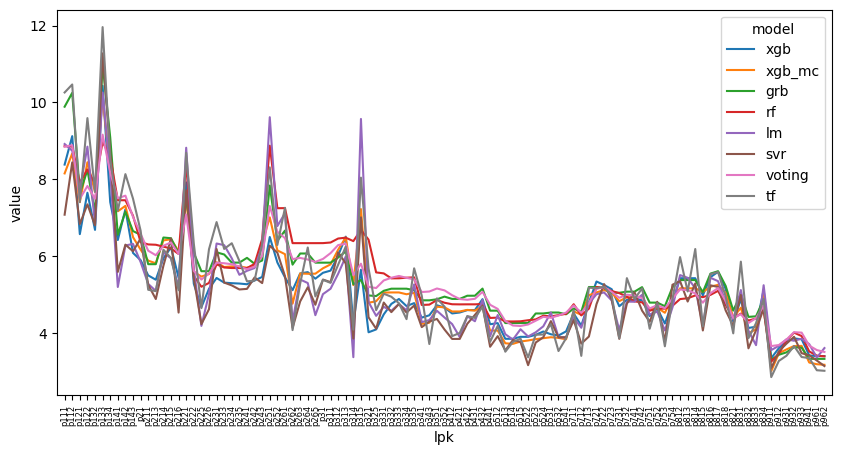

In [159]:
plt.figure(figsize=(10,5))
#models = ['xgb', 'xgb_mc', 'grb', 'rf', 'lm', 'svr', 'voting', 'tf']
selected_models = ['xgb', 'xgb_mc', 'grb', 'rf', 'lm', 'svr', 'voting', 'tf']
sns.lineplot(data=df_ml_long.query('model in @selected_models'),
             x='lpk',
             y ='value',
             hue='model',
             palette='tab10')
plt.xticks(rotation=90, size=6)
plt.margins(x=0.01);

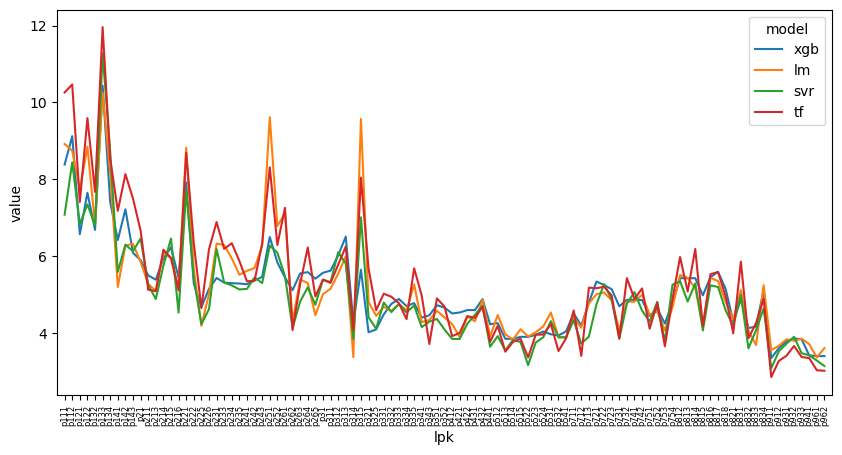

In [160]:
plt.figure(figsize=(10,5))
#models = ['xgb', 'xgb_mc', 'grb', 'rf', 'lm', 'svr', 'voting', 'tf']
selected_models = ['xgb', 'lm', 'svr', 'tf']
sns.lineplot(data=df_ml_long.query('model in @selected_models'),
             x='lpk',
             y ='value',
             hue='model',
             palette='tab10')
plt.xticks(rotation=90, size=6)
plt.margins(x=0.01);

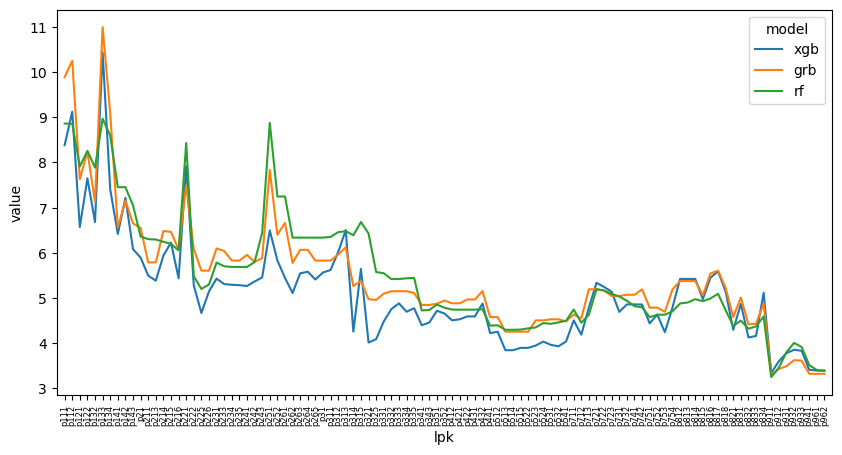

In [161]:
plt.figure(figsize=(10,5))
#models = ['xgb', 'xgb_mc', 'grb', 'rf', 'lm', 'svr', 'voting', 'tf']
selected_models = ['xgb', 'grb', 'rf']
sns.lineplot(data=df_ml_long.query('model in @selected_models'),
             x='lpk',
             y ='value',
             hue='model',
             palette='tab10')
plt.xticks(rotation=90, size=6)
plt.margins(x=0.01);

# Education (need to explore other LPK)!!!!

In [162]:
df = unique_feature_values_with_other_most_common(feature='education')
df.head()

,nace,esize_class,gender,age_class,lpk,education,experience
0,C,GT_250,M,50-59,p833,G1,3.0
1,C,GT_250,M,50-59,p833,G2,3.0
2,C,GT_250,M,50-59,p833,G3,3.0
3,C,GT_250,M,50-59,p833,G4,3.0


In [163]:
df_ml, df_ml_long = apply_models(df)
print(f'df_ml columns: {df_ml.columns.values}')
print(f'df_ml_long columns: {df_ml_long.columns.values}')

1/1 [==============================] - 0s 11ms/step
df_ml columns: ['nace' 'esize_class' 'gender' 'age_class' 'lpk' 'education' 'experience'
 'xgb' 'xgb_mc' 'grb' 'rf' 'lm' 'svr' 'voting' 'tf']
df_ml_long columns: ['nace' 'esize_class' 'gender' 'age_class' 'lpk' 'education' 'experience'
 'model' 'value']


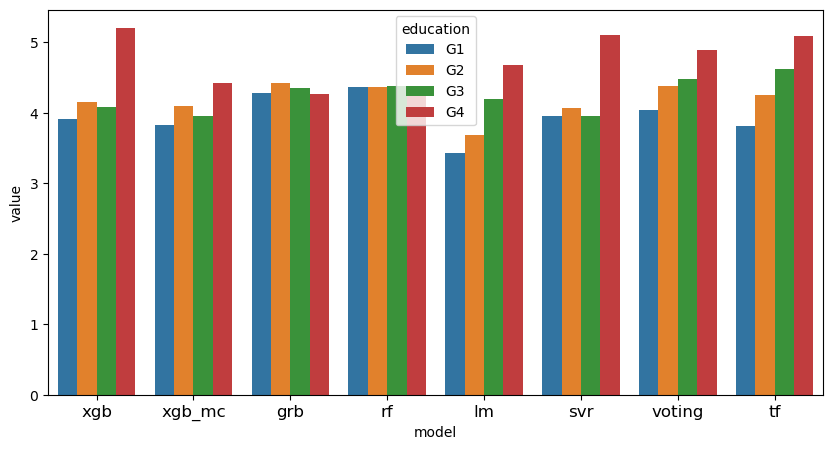

In [169]:
plt.figure(figsize=(10,5))
#models = ['xgb', 'xgb_mc', 'grb', 'rf', 'lm', 'svr', 'voting', 'tf']
selected_models = ['xgb', 'xgb_mc', 'grb', 'rf', 'lm', 'svr', 'voting', 'tf']
sns.barplot(data=df_ml_long.query('model in @selected_models'),
             x='model',
             y ='value',
             hue='education',
             palette='tab10')
plt.xticks(rotation=0, size=12);